## LSTM

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data

In [2]:

CSV_PATH = "AAPL.csv"
TARGET_COL = "Close"
SEQ_LEN = 60
TEST_RATIO = 0.2
EPOCHS = 25
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
FORECAST_DAYS = 10
MODEL_OUT = "LSTM.pt"


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

def extract_dataset(df, test_size = 0.2, history_length = SEQ_LEN):


    train_size = int(len(df) * (1 - test_size))
    test_size = len(df) - test_size

    train = df[:train_size].reset_index(drop=True)
    test =  df[train_size:].reset_index(drop=True)

    def portion_data(stream, history_length):
        X, y = [], []
        for i in range(0, len(stream) - history_length, 1):
            X.append(stream.values[i:i+history_length])
            y.append(stream.values[i+history_length])
        return torch.tensor(X), torch.tensor(y)

    train_x, train_y = portion_data(train, history_length)
    test_x, test_y = portion_data(test, history_length)

    return train_x, train_y, test_x, test_y

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Nie znaleziono pliku: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)[TARGET_COL].astype('float32')

X_train, y_train, X_test, y_test = extract_dataset(df)

def reshape_to_feature(npar):
    return npar.reshape((npar.shape[0], npar.shape[1], 1))

def reshape_to_target(npar):
    return npar.reshape((npar.shape[0], 1))


X_train = reshape_to_feature(X_train)
y_train = reshape_to_target(y_train)
X_test = reshape_to_feature(X_test)
y_test = reshape_to_target(y_test)

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

print(y_train.shape)

torch.Size([9004, 1])


C:\Users\Zosia\AppData\Local\Temp\ipykernel_11356\316463783.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  return torch.tensor(X), torch.tensor(y)


In [4]:
class LSTMRegressor(nn.Module):
    def __init__(self, feature_num, hidden_size1):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=feature_num, hidden_size=hidden_size1,
                             batch_first=True)
        self.fc = nn.Linear(hidden_size1, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        y = self.fc(out)[:, -1, :]
        return y

model = LSTMRegressor(feature_num=1, hidden_size1=64).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb in loader:
        xb = xb.to(DEVICE)  # (batch, seq_len, 1)
        yb = yb.to(DEVICE)  # (batch, 1)

        optimizer.zero_grad()
        preds = model(xb) # (batch, 1)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            X_train = X_train.to(DEVICE)
            X_test = X_test.to(DEVICE)
            y_train = y_train.to(DEVICE)
            y_test = y_test.to(DEVICE)

            y_pred = model(X_train)
            train_rmse = np.sqrt(criterion(y_pred, y_train).cpu())
            y_pred = model(X_test)
            test_rmse = np.sqrt(criterion(y_pred, y_test).cpu())
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


C:\Users\Zosia\AppData\Local\Temp\ipykernel_11356\1959746762.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(criterion(y_pred, y_train).cpu())
C:\Users\Zosia\AppData\Local\Temp\ipykernel_11356\1959746762.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(criterion(y_pred, y_test).cpu())


Epoch 5: train RMSE 0.1617, test RMSE 124.8993
Epoch 10: train RMSE 0.1587, test RMSE 125.7981
Epoch 15: train RMSE 0.1494, test RMSE 126.5453
Epoch 20: train RMSE 0.1970, test RMSE 125.6157
Epoch 25: train RMSE 0.1682, test RMSE 126.7209


In [5]:
torch.save(model.state_dict(), MODEL_OUT)


torch.Size([9004, 1])
tensor([[ 0.0740],
        [ 0.0770],
        [ 0.0761],
        ...,
        [24.6873],
        [25.3511],
        [25.3419]])
torch.Size([2206, 1])
tensor([[ 31.3315],
        [ 31.4171],
        [ 31.6439],
        ...,
        [266.2500],
        [271.4900],
        [276.8600]])


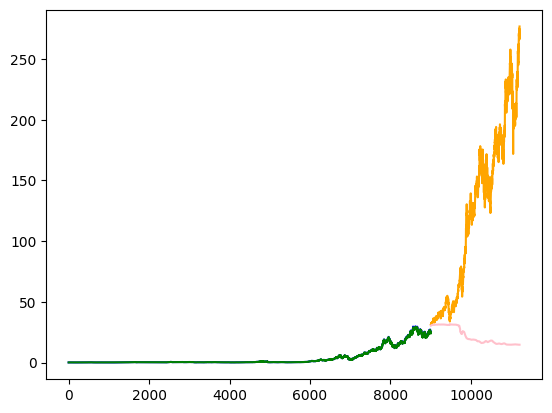

In [6]:
with torch.no_grad():
    model.eval()
    predicted = model(X_train.to(DEVICE)).cpu()

    print(predicted.shape)
    print(y_train)

    plt.plot(y_train.cpu(),c="blue")
    plt.plot(predicted.detach().numpy(),c="green")

with torch.no_grad():
    model.eval()
    predicted = model(X_test.to(DEVICE)).cpu()

    print(predicted.shape)
    print(y_test)

    plt.plot(range(y_train.shape[0], y_train.shape[0] + predicted.shape[0]), y_test.cpu(),c="orange")
    plt.plot(range(y_train.shape[0], y_train.shape[0] + predicted.shape[0]), predicted.detach().numpy(),c="pink")


## Trader

In [7]:
print("Start")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import gymnasium as gym
from stable_baselines3 import PPO

Start


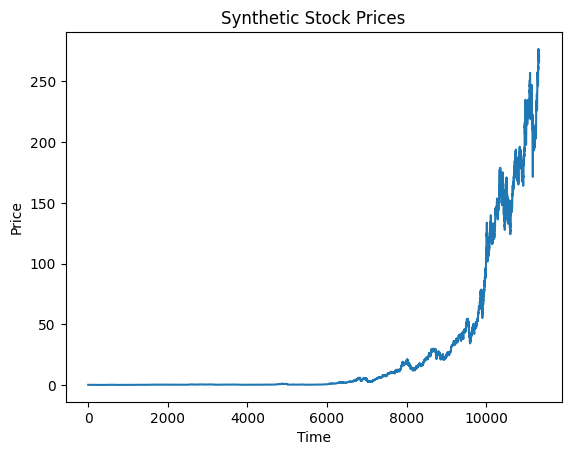

In [9]:
CSV_PATH = "AAPL.csv"
TARGET_COL = "Open"
df = pd.read_csv(CSV_PATH)

plt.plot(df["Open"])
plt.title("Synthetic Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [10]:
df["Open_log_return"] = np.log(df["Open"] / df["Open"].shift(1))
df["Open_log_return"] = df["Open_log_return"].fillna(0.0)
combined_prices_scaled_df = df["Open_log_return"].to_frame()

In [11]:
print(type(combined_prices_scaled_df))
print(type(df))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [12]:
class LSTMRegressor(nn.Module):
    def __init__(self, feature_num, hidden_size1):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=feature_num, hidden_size=hidden_size1,
                             batch_first=True)
        self.fc = nn.Linear(hidden_size1, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        y = self.fc(out)[:, -1, :]
        return y

In [ ]:
model_path = "LSTM.pt"

class StockTradingEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    def __init__(self, df_scaled, original_df, initial_balance=10000, trade_fee_pct=0.01):
        super().__init__()
        self.action_map = {
            0: ("HOLD", 0),
            1: ("BUY", 1),
            2: ("BUY", 5),
            3: ("BUY", 10),
            4: ("SELL", 1),
            5: ("SELL", 5),
            6: ("SELL", 10),
            }
            
        self.action_space = gym.spaces.Discrete(len(self.action_map))
        self.df_scaled = df_scaled 
        self.original_df = original_df 

        self.initial_balance = initial_balance
        self.trade_fee_pct = trade_fee_pct 

        self.balance = self.initial_balance 
        self.shares_held = 0 
        self.net_worth = self.initial_balance 
        self.last_net_worth = self.initial_balance 
        self.current_step = 0
        self.max_steps = len(df_scaled) - 1
        self.seq_len = 60
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        
        self.lstm_model = LSTMRegressor(feature_num=1, hidden_size1=64).to(self.device)
        self.lstm_model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.lstm_model.eval()
        
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(self._get_observation()),), dtype=np.float32)

    def _get_observation(self):
        current_price = self._get_current_price()
        net_worth = self.net_worth if self.net_worth > 0 else 1.0
        position_flag = 1.0 if self.shares_held > 0 else 0.0
        position_value = self.shares_held * current_price
        position_ratio = position_value / net_worth
        cash_ratio = self.balance / net_worth

        obs_space = np.array([
            position_flag,
            position_ratio,
            cash_ratio
        ], dtype=np.float32)

        # --------- Udawany LSTM (fake) 7 dni do przodu ---------
        # fake_preds = []
        # for i in range(1, 8):  # 1 do 7
        #     if self.current_step + i < len(self.original_df):
        #         pred_price = self.original_df['Open'].iloc[self.current_step + i]
        #     else:
        #         pred_price = current_price
        #     fake_preds.append((pred_price - current_price) / current_price)
        # lstm_obs = np.array(fake_preds, dtype=np.float32)

        # --------- Prawdziwy LSTM 7 dni do przodu ---------
        lstm_obs = np.zeros(7, dtype=np.float32)
        if self.current_step >= self.seq_len:
            raw_window = self.original_df['Close'].iloc[self.current_step - self.seq_len : self.current_step].values.reshape(-1, 1)
            input_tensor = torch.tensor(raw_window, dtype=torch.float32).unsqueeze(0).to(self.device)
            self.lstm_model.eval()
            with torch.no_grad():
                # Zakładamy, że model LSTM potrafi multi-step, albo wywołujemy go rekurencyjnie
                pred_price = self.lstm_model(input_tensor).item()
                lstm_obs[0] = (pred_price - current_price) / current_price

                # Rekurencyjnie dla kolejnych 6 dni
                temp_window = raw_window.copy()
                last_price = pred_price
                for j in range(1, 7):
                    temp_window = np.roll(temp_window, -1)
                    temp_window[-1] = last_price
                    input_tensor = torch.tensor(temp_window, dtype=torch.float32).unsqueeze(0).to(self.device)
                    with torch.no_grad():
                        last_price = self.lstm_model(input_tensor).item()
                        lstm_obs[j] = (last_price - current_price) / current_price

        # --------- Dane rynkowe ---------
        market_obs = self.df_scaled.iloc[self.current_step].values.astype(np.float32)

        return np.concatenate([market_obs, obs_space, lstm_obs])  # lub brak

    def _get_current_price(self):
        return self.original_df['Open'].iloc[self.current_step]

    def _take_action(self, action):
        current_price = self._get_current_price()
        action_type, stocks_count = self.action_map[action]

        if action_type == "BUY":  
            available_cash_for_shares = self.balance / (1 + self.trade_fee_pct)

            max_affordable_shares = int(available_cash_for_shares // current_price) if current_price > 0 else 0
            if stocks_count>=max_affordable_shares:
                num_shares_to_buy = max_affordable_shares
            else:
                num_shares_to_buy = min(stocks_count, max_affordable_shares)

            if num_shares_to_buy > 0:
                cost = num_shares_to_buy * current_price * (1 + self.trade_fee_pct)
                self.shares_held += num_shares_to_buy
                self.balance -= cost

        elif action_type == "SELL":  
            if stocks_count >= self.shares_held:
                num_shares_to_sell = int(self.shares_held)
            else:
                num_shares_to_sell = min(stocks_count, int(self.shares_held))

            if num_shares_to_sell > 0:
                proceeds = num_shares_to_sell * current_price * (1 - self.trade_fee_pct)
                self.balance += proceeds
                self.shares_held -= num_shares_to_sell
        elif action_type == "HOLD": 
            pass
        
        self.net_worth = self.balance + (self.shares_held * current_price)

    def _get_reward(self):
        reward = self.net_worth - self.last_net_worth
        self.last_net_worth = self.net_worth
        return reward

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.last_net_worth = self.initial_balance
        self.current_step = 0

        observation = self._get_observation()
        info = {}
        return observation, info

    def step(self, action):
        self.last_net_worth = self.net_worth 
        self._take_action(action)

        reward = self._get_reward()

        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False 

        observation = self._get_observation() if not terminated else np.zeros_like(self._get_observation())
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        if mode == 'human':
            print(f"Step: {self.current_step}")
            print(f"Balance: {self.balance:.2f}")
            print(f"Price: {self._get_current_price():.2f}")

In [ ]:
env = StockTradingEnv(
    df_scaled=combined_prices_scaled_df,
    original_df=df,
    initial_balance=100,
    trade_fee_pct=0.001
)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1906 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1347         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0027536768 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | -0.00524     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.505        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000625    |
|    val

In [ ]:
obs, _ = env.reset()
done = False

buys_x=[]
buys_y=[]
sells_x=[]
sells_y=[]
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(int(action))
    if action in [1,2,3]:
        buys_x.append(env.current_step)
        buys_y.append(env._get_current_price())
    if action in [4,5,6]:
        sells_x.append(env.current_step)
        sells_y.append(env._get_current_price())    
    if terminated:
        break



In [ ]:
print("Total profit:", env.balance)

Total profit: 12.712885309596727


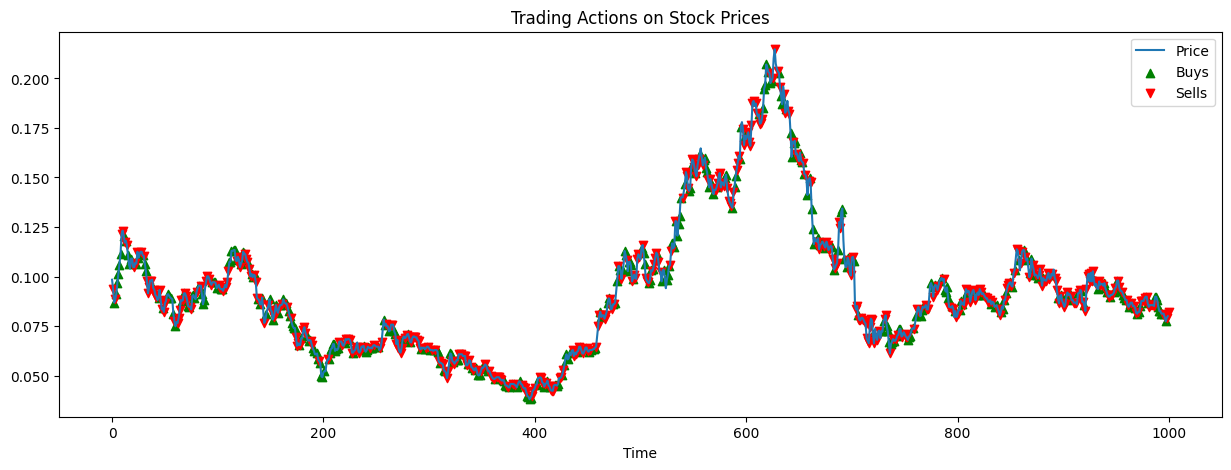

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df["Open"][0:1000], label="Price")
ax.scatter(buys_x, buys_y, marker="^", color="g", label="Buys")
ax.scatter(sells_x, sells_y, marker="v", color="r", label="Sells")
ax.set_title("Trading Actions on Stock Prices")
ax.set_xlabel("Time")
ax.legend()
plt.show()
